# **Skin Cancer: Malignant vs. Benign**

In [ ]:
!pip install mplcyberpunk
!pip install torchutils
! pip install kaggle

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms as T
from torchvision import datasets
import torchutils as tu
import torchvision.models as models

from google.colab import files
import os
import shutil

import mplcyberpunk
import matplotlib.pyplot as plt
plt.style.use('cyberpunk')
import numpy as np

import cv2
import math

# Скачиваем данные

In [ ]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

Dataset URL: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign
License(s): unknown
100% 324M/325M [00:12<00:00, 30.8MB/s]
100% 325M/325M [00:12<00:00, 27.4MB/s]


In [ ]:
!unzip skin-cancer-malignant-vs-benign.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/train/benign/420.jpg  
  inflating: data/train/benign/421.jpg  
  inflating: data/train/benign/422.jpg  
  inflating: data/train/benign/423.jpg  
  inflating: data/train/benign/424.jpg  
  inflating: data/train/benign/425.jpg  
  inflating: data/train/benign/426.jpg  
  inflating: data/train/benign/429.jpg  
  inflating: data/train/benign/43.jpg  
  inflating: data/train/benign/430.jpg  
  inflating: data/train/benign/431.jpg  
  inflating: data/train/benign/432.jpg  
  inflating: data/train/benign/434.jpg  
  inflating: data/train/benign/435.jpg  
  inflating: data/train/benign/438.jpg  
  inflating: data/train/benign/439.jpg  
  inflating: data/train/benign/440.jpg  
  inflating: data/train/benign/441.jpg  
  inflating: data/train/benign/442.jpg  
  inflating: data/train/benign/443.jpg  
  inflating: data/train/benign/445.jpg  
  inflating: data/train/benign/446.jpg  
  inflating: data/train/benign/

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Читаем данные

In [3]:
train_path = 'train'
test_path = 'test'
labels = os.listdir(train_path)
labels

['malignant', 'benign']

In [4]:
def show_img_path(img_path):
    image = cv2.imread(img_path)
    print('img shape:', image.shape)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

img shape: (224, 224, 3)


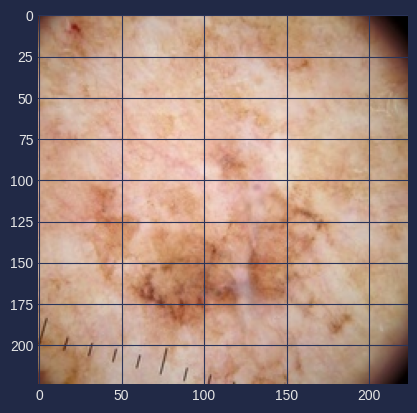

img shape: (224, 224, 3)


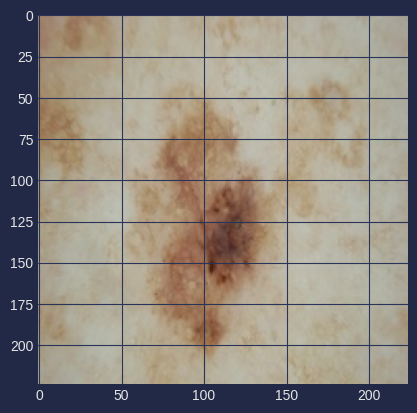

In [5]:
# malignant
show_img_path('test/malignant/1.jpg')

show_img_path('train/malignant/10.jpg')

img shape: (224, 224, 3)


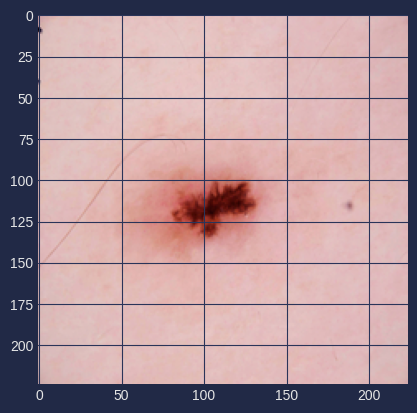

img shape: (224, 224, 3)


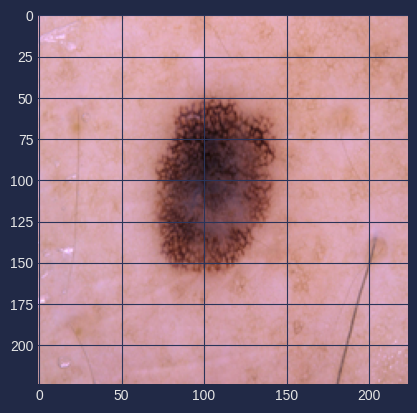

In [6]:
# benign
show_img_path('test/benign/1.jpg')

show_img_path('train/benign/100.jpg')

In [7]:
train_transform = T.Compose([
    # T.Resize((224, 224)),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(),
    T.ToTensor()
])
test_transform = T.Compose([
    T.ToTensor(),
    ])
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)


In [9]:
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
batch = next(iter(train_loader))

batch_images = batch[0]
batch_labels = batch[1]

fig,axs = plt.subplots(nrows = 8, ncols = 4, figsize = (12, 24))
axs = axs.flat

for i,img in enumerate(batch_images):
    image = img.permute(1,2,0)
    axs[i].imshow(image)
    axs[i].axis('off')

fig.tight_layout()
fig.show()

# Модель

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(os.listdir(train_path)))
class_counts

2

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, class_counts)

model = model.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
tu.get_model_summary(model, torch.randn(32,3,224,224).to(device))

Layer                                         Kernel               Output          Params             FLOPs
0_conv1                                      [3, 64, 7, 7]   [32, 64, 112, 112]       9,408   3,776,446,464
1_bn1                                                 [64]   [32, 64, 112, 112]         128     102,760,448
2_relu                                                   -   [32, 64, 112, 112]           0               0
3_maxpool                                                -     [32, 64, 56, 56]           0               0
4_layer1.0.Conv2d_conv1                     [64, 64, 1, 1]     [32, 64, 56, 56]       4,096     411,041,792
5_layer1.0.BatchNorm2d_bn1                            [64]     [32, 64, 56, 56]         128      25,690,112
6_layer1.0.ReLU_relu                                     -     [32, 64, 56, 56]           0               0
7_layer1.0.Conv2d_conv2                     [64, 64, 3, 3]     [32, 64, 56, 56]      36,864   3,699,376,128
8_layer1.0.BatchNorm2d_bn2  

# Создаем нужные функции

In [ ]:
# для отображения графика
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,5))

    ax[0].plot(history['train_loss'], label='train loss')
    ax[0].plot(history['valid_loss'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_loss"])}')
    ax[0].grid(grid)
    ax[0].legend()

    ax[1].plot(history['train_acc'], label='train acc')
    ax[1].plot(history['valid_acc'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_loss"])}')
    ax[1].grid(grid)
    ax[1].legend()

    plt.show()

In [ ]:
def compute_batch_accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

In [1]:
epochs = 50
def run_epoches(model, criterion, optimizer, epochs):
    history ={
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': []
    }
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        loss_batch = []
        acc_batch  = []
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, labels)
            loss_batch.append(loss.item())
            acc_batch.append(compute_batch_accuracy(preds, labels))
            loss.backward()
            optimizer.step()

        history['train_loss'].append(np.mean(loss_batch))
        history['train_acc'].append(np.mean(acc_batch))

        model.eval()
        loss_batch = []
        acc_batch  = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            loss_batch.append(loss.item())
            acc_batch.append(compute_batch_accuracy(preds, labels))

        history['valid_loss'].append(np.mean(loss_batch))
        history['valid_acc'].append(np.mean(acc_batch))

        print(
            f'train: accuracy {history["train_acc"][-1]:.3f}, loss {history["train_loss"][-1]:.3f}',
            f'valid: accuracy {history["valid_acc"][-1]:.3f}, loss {history["valid_loss"][-1]:.3f}',
        )

        print()
    return history
history = None
history = run_epoches(model, criterion, optimizer, epochs)

NameError: name 'model' is not defined

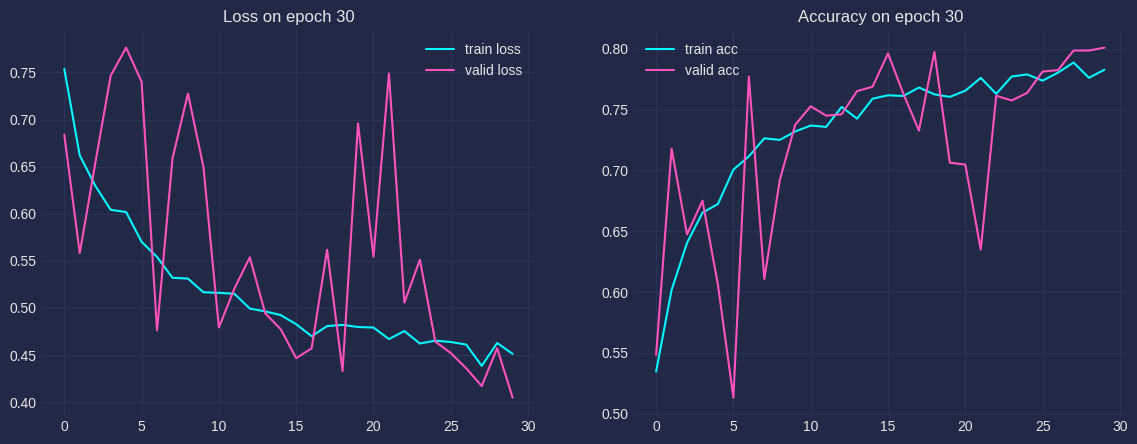

In [ ]:
plot_history(history)

# Сохраняем модель

In [ ]:
torch.save(model.state_dict(), 'cancer_model.pth')



# Смотрим модель

In [ ]:
! pip install torchview

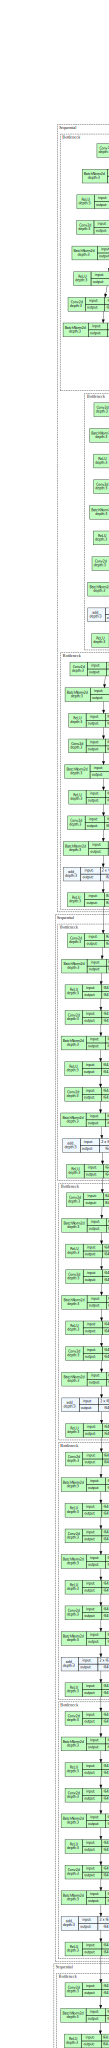

In [ ]:
from torchview import draw_graph
model_graph = draw_graph(
    model,
    input_size=[64, 3, 7, 7],
    expand_nested=True
    )
model_graph.visual_graph

In [ ]:
!pip install streamlit
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 100.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [ ]:
!streamlit run app.py

In [ ]:
from pyngrok import ngrok

# Запускаем Streamlit
!streamlit run app.py &

# Устанавливаем ngrok
public_url = ngrok.connect(port='8501')
public_url




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.185.162.134:8501

